In [355]:
#Questions
# - dense layer?
# - model doing better with less layers?
# - tuning layers
# - construct a class to test model differences
# - visualize model flow?
# - visualize filter outputs?
# - modeling doing better during validation than training?

### Categorizing Clothing using CNN
1. Data Exploration
2. Data Processing
3. Modeling
4. Model Evaluation
5. Prediction

In [404]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

np.random.seed(2)
sns.set(style='white', context='notebook',palette='mako')

### Data Exploration & Preprocessing

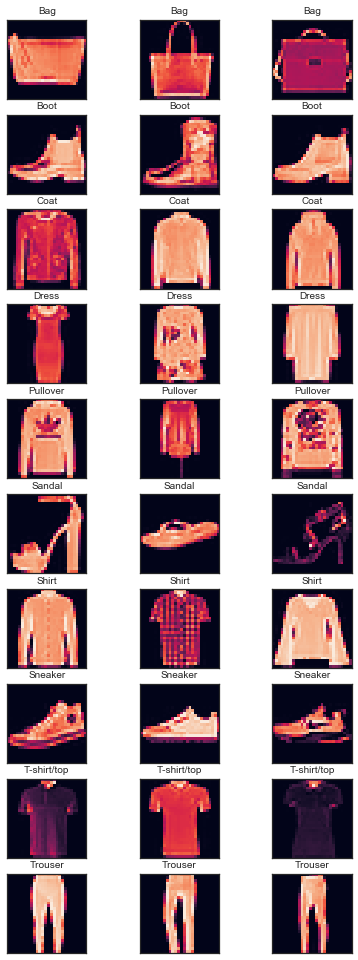

In [455]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot sample of categories
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10,3, figsize = (6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

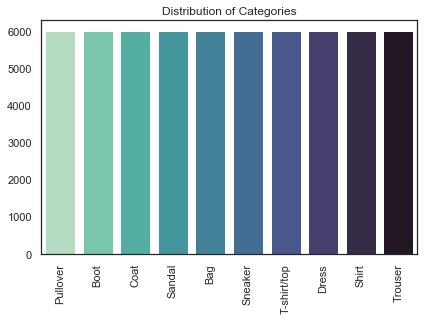

In [412]:
#plot distribution of categories
category_series = pd.Series(y_train).map(categories)
category_counts = category_series.value_counts()
sns.barplot(category_counts.index, category_counts, palette='mako_r')
ticks=plt.xticks(rotation='vertical')
title=plt.title('Distribution of Categories')

In [427]:
#check for nulls
print(f'Nulls in x_train: {np.isnan(x_train).sum()}')
print(f'Nulls in x_test: {np.isnan(x_test).sum()}')
print(f'Nulls in y_train: {np.isnan(y_train).sum()}')
print(f'Nulls in y_test: {np.isnan(y_test).sum()}')

Nulls in x_train: 0
Nulls in x_test: 0
Nulls in y_train: 0
Nulls in y_test: 0


In [458]:
#scaling to ease computational burden of model; CNN converges faster on [0,1] data than on [0,255]
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels) for keras
#since images are grayscale, only use one channel
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#create validation set
#because we have uniform distribution of y labels, no need to stratify
#random_seed = 2
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_scaled_shape, y_train_cat, test_size = 0.2, random_state = random_seed)


### Convolutional Neural Net with Keras

In [357]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()

#     def fit_model(self, epochs=3, batch_size=100):
#         kernels = self.kernels
#         filters = self.filters
#         model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
#                             Flatten(),
#                             Dense(10, activation='softmax')])
#         start_time = time.time()
#         model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#         end_time = time.time()
#         model_time = end_time - start_time
#         model_output=model.fit(x_train_scaled_shape, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1, 
#                          shuffle=True, validation_split=0.2)
#         history = pd.DataFrame(model_output.history)
#         history['epoch'] = list(range(1, epochs+1))
#         history['model_time'] = model_time
#         history['filters'] = filters
#         history['kernel_size'] = str(kernels)
#         return history
    
    def create_model(self):
        '''Simple Sequential model using variations of kernel size and number of filters as indicated by the user'''
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
    

    def fit_model(self, model, epochs=3, batch_size=100):
        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(x_test_scaled_shape, y_test_cat), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [358]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=3, batch_size=100)
    all_results = all_results.append(model_results)
    
all_results.head()

Epoch 1/3
600/600 [==============================] - 15s 26ms/step - loss: 0.7883 - accuracy: 0.7153 - val_loss: 0.5831 - val_accuracy: 0.7851
Epoch 2/3
600/600 [==============================] - 14s 23ms/step - loss: 0.6294 - accuracy: 0.7689 - val_loss: 0.5299 - val_accuracy: 0.8137
Epoch 3/3
600/600 [==============================] - 15s 24ms/step - loss: 0.5907 - accuracy: 0.7838 - val_loss: 0.5098 - val_accuracy: 0.8199
Epoch 1/3
600/600 [==============================] - 14s 24ms/step - loss: 0.7692 - accuracy: 0.7195 - val_loss: 0.5715 - val_accuracy: 0.7855
Epoch 2/3
600/600 [==============================] - 14s 23ms/step - loss: 0.6000 - accuracy: 0.7820 - val_loss: 0.4950 - val_accuracy: 0.8214
Epoch 3/3
600/600 [==============================] - 14s 23ms/step - loss: 0.5602 - accuracy: 0.7956 - val_loss: 0.5019 - val_accuracy: 0.8151
Epoch 1/3
600/600 [==============================] - 16s 27ms/step - loss: 0.6875 - accuracy: 0.7468 - val_loss: 0.4943 - val_accuracy: 0.8156

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.583104,0.7851,0.788336,0.715267,1,44.813569,5,"(5, 5)"
1,0.529923,0.8137,0.629394,0.768933,2,44.813569,5,"(5, 5)"
2,0.509806,0.8199,0.590717,0.783833,3,44.813569,5,"(5, 5)"
0,0.571483,0.7855,0.769151,0.719533,1,42.636792,10,"(5, 5)"
1,0.495004,0.8214,0.600005,0.782000,2,42.636792,10,"(5, 5)"


In [359]:
max_acc = all_results['accuracy'].max()
all_results[all_results['accuracy'] == max_acc]
all_results.sort_values('accuracy',ascending=False)

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
2,0.424225,0.8495,0.483442,0.820100,3,52.509024,60,"(5, 5)"
2,0.429432,0.8487,0.495081,0.817617,3,48.198687,30,"(5, 5)"
2,0.435485,0.8380,0.509304,0.809667,3,58.831889,60,"(10, 10)"
2,0.440286,0.8447,0.522305,0.808417,3,53.245614,30,"(10, 10)"
1,0.472472,0.8237,0.517938,0.808283,2,52.509024,60,"(5, 5)"
1,0.466996,0.8275,0.531939,0.804200,2,48.198687,30,"(5, 5)"
2,0.459617,0.8288,0.536894,0.798733,3,61.397056,60,"(15, 15)"
2,0.501908,0.8151,0.560225,0.795633,3,42.636792,10,"(5, 5)"
1,0.472250,0.8277,0.548548,0.795383,2,58.831889,60,"(10, 10)"
2,0.474465,0.8276,0.557237,0.791550,3,51.412345,30,"(15, 15)"


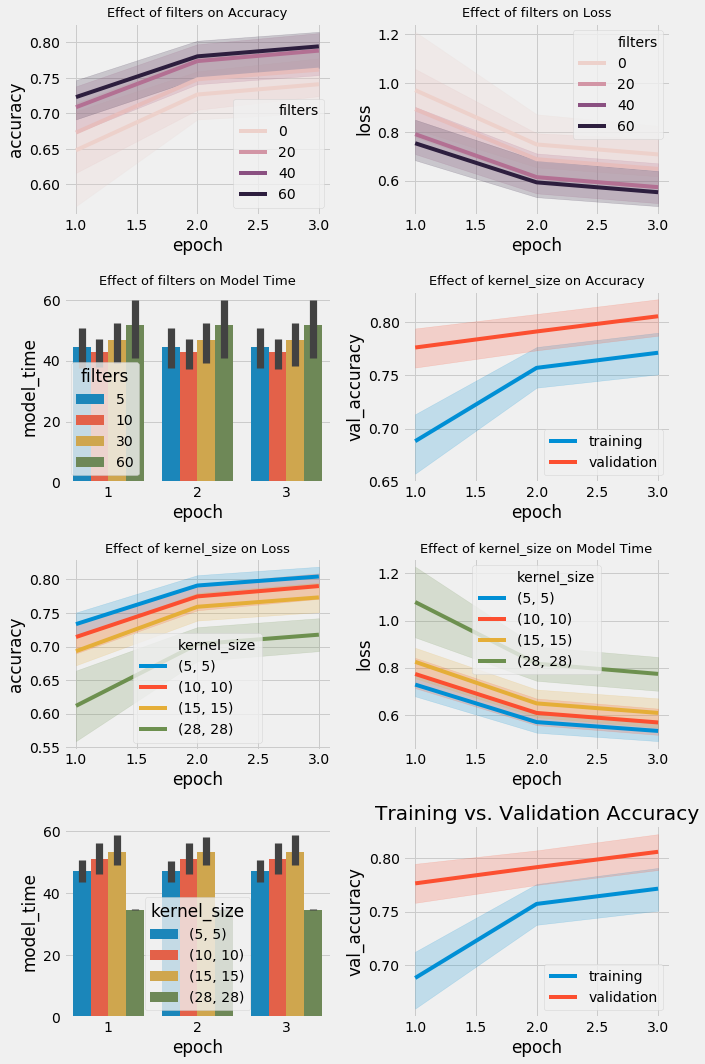

In [360]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(4,2,figsize=(10,15))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*4])
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=13)
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*4+1])
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=13)
    sns.barplot('epoch','model_time',data=all_results, hue=metric, ax=axes[i*4+2])
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=13)
    sns.lineplot('epoch','accuracy',data=all_results,ax=axes[i*4+3], label='training')
    sns.lineplot('epoch','val_accuracy',data=all_results,ax=axes[i*4+3], label='validation')
    axes[i*4+3].legend()
    axes[i*4+3].set_title('Training vs. Validation Accuracy')
    plt.tight_layout()

In [462]:
model_advanced = Sequential([Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation='softmax')])

model_advanced.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_advanced.summary()
epochs=3
batch_size=100

history_no_aug = model_advanced.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs,
                                  validation_data=(x_val_split, y_val_split), verbose=1)

Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_329 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_332 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 32)       

In [466]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train_split)

history_advanced = model.fit_generator(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                                                   epochs=epochs, validation_data=(x_val_split, y_val_split),
                                                   verbose=1, steps_per_epoch=x_train_split.shape[0]//batch_size)

Epoch 1/3
480/480 [==============================] - 10s 20ms/step - loss: 0.7492 - accuracy: 0.7328 - val_loss: 0.5633 - val_accuracy: 0.7900
Epoch 2/3
480/480 [==============================] - 10s 20ms/step - loss: 0.6746 - accuracy: 0.7521 - val_loss: 0.5362 - val_accuracy: 0.8058
Epoch 3/3
480/480 [==============================] - 10s 20ms/step - loss: 0.6582 - accuracy: 0.7578 - val_loss: 0.5275 - val_accuracy: 0.8018


### Visualizing Filters

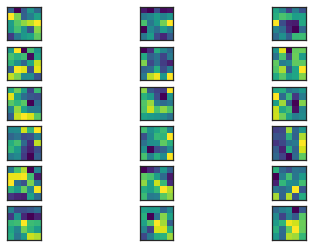

In [527]:
layer_dict = dict([(layer.name, layer) for layer in model_advanced.layers])
layer_name = 'conv2d_331'
filter_index = 0

filters, biases = layer_dict[layer_name].get_weights()

f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters-f_min)/(f_max-f_min)

n_filters, index = 6,1
for i in range(n_filters):
    f = filters[:,:,:,i]
    
    for j in range(3):
        ax=plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,j], cmap='viridis')
        index +=1
plt.show()

### Prediction analysis

In [363]:
#find best model
#best_model = all_results[all_results['accuracy']==all_results['accuracy'].max()]
best_params = {'kernels':(3,3), 'filters':60}
best_model = CNN(best_params)
prediction_model = best_model.create_model()
history = best_model.fit_model(prediction_model)

#calculate predictions
predictions = prediction_model.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
counter = Counter()
for x,y in list(zip(predicted, y_test)):
    if x==y:
        counter[y]+=1
counter

Epoch 1/3
600/600 [==============================] - 19s 32ms/step - loss: 0.6947 - accuracy: 0.7462 - val_loss: 0.5299 - val_accuracy: 0.8010
Epoch 2/3
600/600 [==============================] - 17s 29ms/step - loss: 0.5387 - accuracy: 0.8007 - val_loss: 0.4689 - val_accuracy: 0.8346
Epoch 3/3
600/600 [==============================] - 17s 28ms/step - loss: 0.5013 - accuracy: 0.8160 - val_loss: 0.4318 - val_accuracy: 0.8467


Counter({9: 933,
         2: 732,
         1: 968,
         6: 540,
         5: 978,
         7: 933,
         4: 773,
         3: 887,
         8: 950,
         0: 773})

In [364]:
pred_df = pd.DataFrame(zip(predicted, y_test)).rename(columns={0:'predicted',1:'actual'})
pred_df['predicted_label'] = pred_df['predicted'].map(categories)
pred_df['actual_label'] = pred_df['actual'].map(categories)
pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False)
display(correct)

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False)
top5_wrong = wrong.nlargest(10, 'correct')
display(wrong)

,correct
actual_label,
Sandal,978.0
Trouser,968.0
Bag,950.0
Boot,933.0
Sneaker,933.0
Dress,887.0
Coat,773.0
T-shirt/top,773.0
Pullover,732.0


correct
actual_label predicted_label         
Shirt        T-shirt/top          161
Pullover     Coat                 131
Shirt        Coat                 115
Pullover     Shirt                111
Shirt        Pullover             110
T-shirt/top  Shirt                101
             Dress                 86
Coat         Pullover              85
             Shirt                 82
Shirt        Dress                 65
Coat         Dress                 57
Boot         Sneaker               51
Dress        Shirt                 42
Sneaker      Sandal                40
             Boot                  27
Trouser      Dress                 23
Bag          Shirt                 21
Dress        Trouser               21
Sandal       Sneaker               20
Dress        Coat                  20
             T-shirt/top           19
T-shirt/top  Pullover              15
Boot         Sandal                15
Pullover     T-shirt/top           11
T-shirt/top  Coat                  11
Dress        Pullover              10
Pullover     Dress                 10
T-shirt/top  Bag                    8
Bag          Dress                  6
Shirt        Bag                    6
Trouser      Coat                   5
Bag          T-shirt/top            5
             Coat                   4
             Trouser                4
             Sneaker                4
T-shirt/top  Sandal                 4
Bag          Sandal                 3
Pullover     Trouser                2
Sandal       Boot                   2
Shirt        Trouser                2
Trouser      Pullover               2
Pullover     Bag                    2
T-shirt/top  Trouser                2
Bag          Boot                   2
Trouser      Bag                    1
Pullover     Sandal                 1
Shirt        Sandal                 1
Dress        Bag                    1
Coat         T-shirt/top            1
             Sandal                 1
             Bag                    1
Boot         Bag                    1
Bag          Pullover               1
Trouser      Shirt                  1

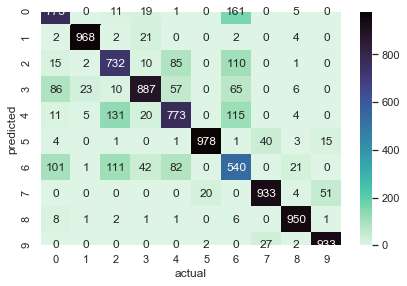

In [518]:
df = pd.DataFrame(y_test).rename(columns={0:'actual'})
df['predicted'] = predicted
df['count'] = 1
df.groupby(['actual','predicted']).count()
df_index = df.reset_index()
pivot = df_index.pivot_table('count',index='predicted',columns='actual',aggfunc='sum')
pivot_nona = pivot.fillna(0)
sns.heatmap(pivot_nona, cmap='mako_r', annot=True, fmt='.0f')

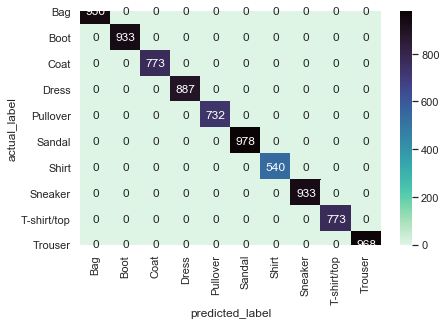

In [515]:
predicted_pivot =pred_df.pivot_table('correct',index='actual_label',columns='predicted_label',aggfunc='sum').fillna(0)
sns.heatmap(predicted_pivot, cmap='mako_r', annot=True, fmt='.0f')

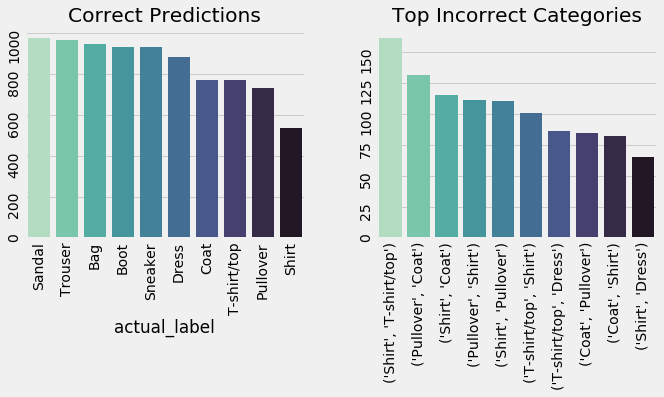

In [383]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
axes[0].tick_params(labelrotation=90)
axes[0].set_ylabel('')

sns.barplot(top5_wrong.index, top5_wrong['correct'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Categories')
plt.tight_layout()
axes[1].tick_params(labelrotation=90)
y=axes[1].set_ylabel('')

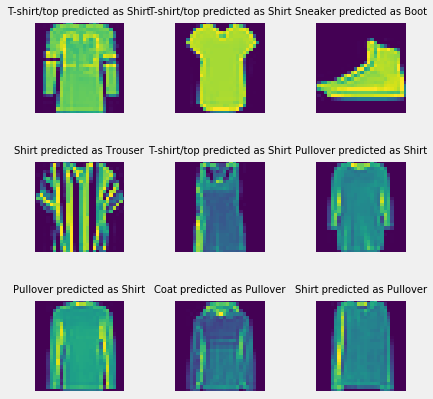

In [385]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=10)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

In [368]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')